<h1>Table of Contents<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"></ul></div>

In [1]:
push!(LOAD_PATH, ".")
using RobustOptimization
using Ipopt, JuMP, PyPlot
using ScikitLearn
@sk_import model_selection: train_test_split
@sk_import metrics: roc_curve
@sk_import metrics: roc_auc_score
@sk_import metrics: accuracy_score
@sk_import metrics: classification_report
path_train = "datasets/ionosphere_scale"
nbfeatures = 34
data_train = read_data_libsvm(path_train, nbfeatures);
# xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.15)
# ab_train = hcat(xtr, ytr)
# aux_train = ab_train[ab_train[:,end] .< 0,:]
# ll_train = vcat(aux_train,data_train[data_train[:,end].>0,:])

rs = 75
xtr, xte, ytr, yte = train_test_split(data_train[:,1:end-1], data_train[:,end], train_size = 0.6, random_state = rs)
df_train = hcat(xtr, ytr)
# low_train = hcat(xtr, ytr)
df_aux= hcat(xte, yte);

In [2]:
# df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.2, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 500
itmax = 10000
sample = N

ambiguity = "KLdivergence"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# α = 0.1
projParams = ProjParams(Int(40), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [3]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))


******************************************************************************
This program contains Ipopt, a library for large-scale nonlinear optimization.
 Ipopt is released as open source code under the Eclipse Public License (EPL).
         For more information visit http://projects.coin-or.org/Ipopt
******************************************************************************



([0.0, 0.0192308, 0.153846, 0.153846, 0.173077, 0.173077, 0.192308, 0.192308, 0.211538, 0.211538  …  0.480769, 0.5, 0.5, 0.519231, 0.519231, 0.538462, 0.538462, 0.557692, 0.557692, 1.0], [0.0, 0.0, 0.0, 0.0449438, 0.0449438, 0.0898876, 0.0898876, 0.213483, 0.213483, 0.314607  …  0.955056, 0.955056, 0.966292, 0.966292, 0.977528, 0.977528, 0.988764, 0.988764, 1.0, 1.0], [2.0, 1.0, 1.0, 0.999992, 0.999991, 0.999973, 0.999972, 0.999794, 0.999733, 0.998022  …  0.536114, 0.391011, 0.358508, 0.350994, 0.245074, 0.202028, 0.198651, 0.0562994, 0.0522239, 1.06549e-23])

In [4]:
e_tab = [0.0001,0.0005,0.0006,0.0007,0.0008,0.0009,
            0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,
            0.01,0.05,0.1,0.5]
# e_tab = [0.001,0.002,0.003,0.004,0.005,0.006,0.007,0.008,0.009,0.01,0.05,0.1,0.5,1.0]

19-element Array{Float64,1}:
 0.0001
 0.0005
 0.0006
 0.0007
 0.0008
 0.0009
 0.001 
 0.002 
 0.003 
 0.004 
 0.005 
 0.006 
 0.007 
 0.008 
 0.009 
 0.01  
 0.05  
 0.1   
 0.5   

In [20]:
dm_tab = []
time_tab = []
xr1_tab = []
xr2_tab = []
fpr1_tab = []
tpr1_tab = []
fpr2_tab = []
tpr2_tab = []
for ϵ in e_tab
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = initialize(df_train, robustModel, KLConstraint())
    xalg, yalg, dm, mem, mini, t_iter = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(time_tab, t_iter)
    push!(dm_tab, dm)
    push!(xr1_tab, xrobust1)
    push!(xr2_tab, xrobust2)
    push!(fpr1_tab, fpr1)
    push!(tpr1_tab, tpr1)
    push!(fpr2_tab, fpr2)
    push!(tpr2_tab, tpr2)
end

 
espilon = 0.0001
 
500 0.03997732544919952 1000 0.028729831878568923 1500 0.02380124270041506 2000 0.020567928256423063 2500 0.01842679976181838 3000 0.01688702694286892 3500 0.015704216947227234 4000 0.014781897643430852 4500 0.014062541129253425 5000 0.013474921848775523 5500 0.012989516477049268 6000 0.012572464400742334 6500 0.012208609262868375 7000 0.011871577804784206 7500 0.011570005438811481 8000 0.01129833625977561 8500 0.011045678903999434 9000 0.010815050016902639 9500 0.010604630539244653 10000 0.010409923790902553  
espilon = 0.0005
 
500 0.03989090962345854 1000 0.028960479440693465 1500 0.024292454064628988 2000 0.021226276648013798 2500 0.01911211853689876 3000 0.01759181257363185 3500 0.016455811845493606 4000 0.01555562892911766 4500 0.014835664835005868 5000 0.014248783034824353 5500 0.01374176586214837 6000 0.01329474936461672 6500 0.012896265951507502 7000 0.012534931813252381 7500 0.012206157981205834 8000 0.011908022031807963 8500 0.011636393606789142 9000 0.0

In [217]:
for i in 1:(size(e_tab)[1]-1)
    plot(dm_tab[i][1:8000]-dm_tab[i][end], label="ϵ = $(e_tab[i])")
end
legend()

LoadError: [91mUndefVarError: dm_tab not defined[39m

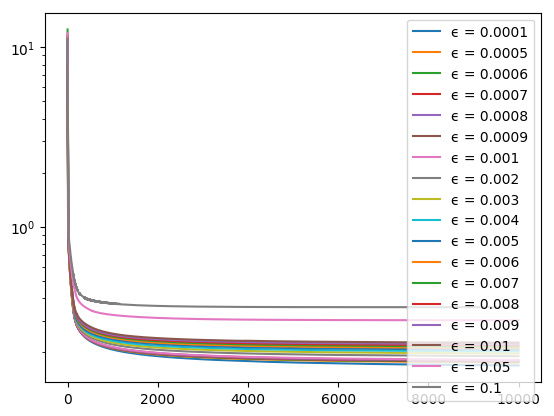

PyObject <matplotlib.legend.Legend object at 0x7fdba8e2f6d8>

In [6]:
for i in 1:(size(e_tab)[1]-1)
    plot((dm_tab[i]), label="ϵ = $(e_tab[i])")
    yscale("log")
end
legend()

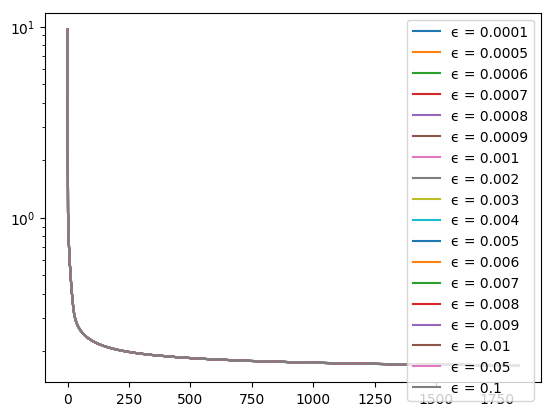

PyObject <matplotlib.legend.Legend object at 0x7fdba342ccf8>

In [7]:
for i in 1:(size(e_tab)[1]-1)
    plot(cumsum(time_tab[1]), dm_tab[1], label="ϵ = $(e_tab[i])")
    yscale("log")
end
legend(loc=1)

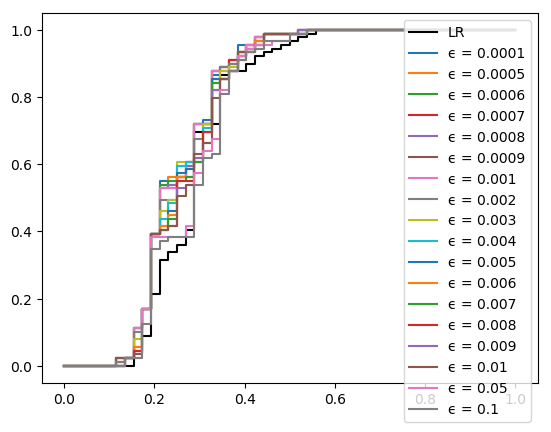

PyObject <matplotlib.legend.Legend object at 0x7fcc99cb7e48>

In [31]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:(size(e_tab)[1]-1)
     plot(fpr1_tab[i], tpr1_tab[i], label="ϵ = $(e_tab[i])")
end
legend()

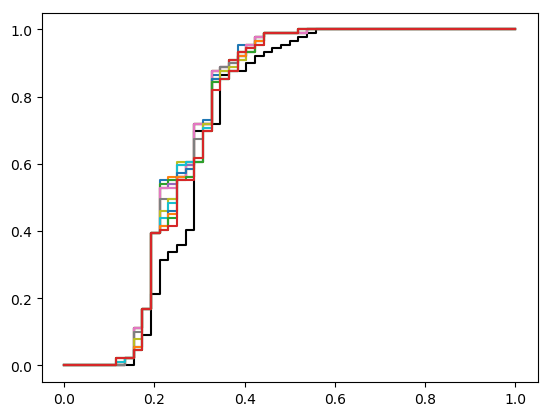

In [25]:
plot(fpr,tpr, color="black")
for i in 1:14
     plot(fpr2_tab[i], tpr2_tab[i])
end

0.7134831460674158  0.7943262411347518
0.7474070872947277  0.8226950354609929
0.7474070872947277  0.8226950354609929
0.747191011235955  0.8226950354609929
0.7467588591184097  0.8226950354609929
0.746542783059637  0.8226950354609929
0.746542783059637  0.8226950354609929
0.7463267070008642  0.8226950354609929
0.7439498703543648  0.8226950354609929
0.7415730337078652  0.8226950354609929
0.7394122731201382  0.8226950354609929
0.7376836646499567  0.8226950354609929


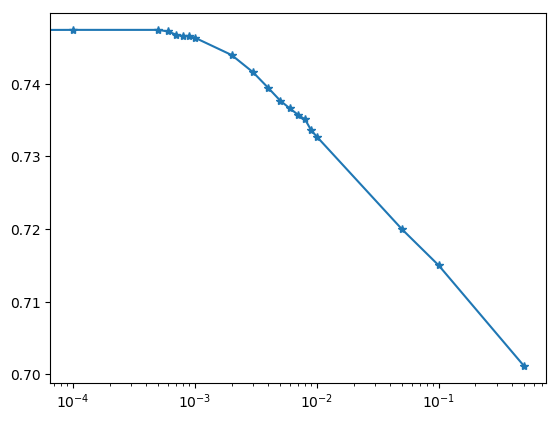

0.7366032843560933  0.8226950354609929
0.7357389801210026  0.8156028368794326
0.7350907519446845  0.8156028368794326
0.7335782195332756  0.8085106382978723
0.732713915298185  0.8085106382978723
0.7199654278305964  0.8085106382978723
0.7149956784788245  0.8085106382978723
0.7011668107173725  0.7943262411347518


In [38]:
plt_AUC = []
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
push!(plt_AUC,roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:(size(e_tab)[1])
    push!(plt_AUC, roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_tab[i], LogisticRegression())))
end
plot(vcat([0],e_tab),plt_AUC, marker="*")
xscale("log")

0.7134831460674158  0.7943262411347518


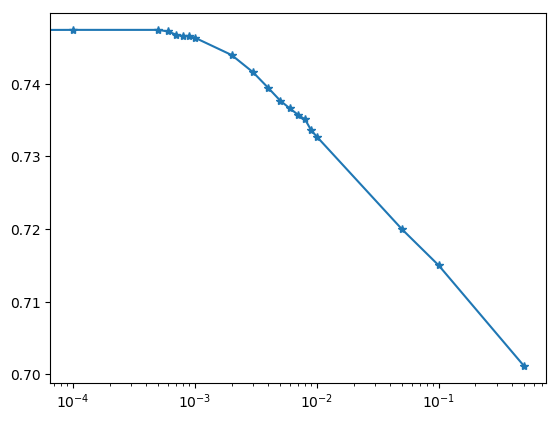

0.7474070872947277  0.8226950354609929
0.7474070872947277  0.8226950354609929
0.747191011235955  0.8226950354609929
0.7467588591184097  0.8226950354609929
0.746542783059637  0.8226950354609929
0.746542783059637  0.8226950354609929
0.7463267070008642  0.8226950354609929
0.7439498703543648  0.8226950354609929
0.7415730337078652  0.8226950354609929
0.7394122731201382  0.8226950354609929
0.7376836646499567  0.8226950354609929
0.7366032843560933  0.8226950354609929
0.7357389801210026  0.8156028368794326
0.7350907519446845  0.8156028368794326
0.7335782195332756  0.8085106382978723
0.732713915298185  0.8085106382978723
0.7199654278305964  0.8085106382978723
0.7149956784788245  0.8085106382978723
0.7011668107173725  0.7730496453900709


In [39]:
plt_AUC = []
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
push!(plt_AUC,roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:(size(e_tab)[1])
    push!(plt_AUC, roc_auc_score(df_aux[:,end], positive_rate(xr1_tab[i],df_aux)))
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_tab[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_tab[i], LogisticRegression())))
end
plot(vcat([0],e_tab),plt_AUC, marker="*")
xscale("log")

In [5]:
# @everywhere df_train, df_aux = create_data("diabetes_scale", nbfeatures, 0.7, train_test_split)
solver = IpoptSolver(print_level = 2)
N = size(df_train)[1]
ϵ = 0.05
verbosity = 1
itmax = 2000
sample = 1500

ambiguity = "wasserstein"
robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
α = 1/norm(robustModel.descent_direction)
# α = 1.0
projParams = ProjParams(Int(200), 1e-5, sample, para_proj=Sequential(), para_inter=Sequential())
optParams = OptParams(itmax, 1e-5, α, verbosity = verbosity);

In [398]:
xnormal = normal_opt(df_train, solver, robustModel.regressionModel)
fpr, tpr, thresholds = roc_curve(df_aux[:,end], positive_rate(xnormal,df_aux))

([0.0, 0.0192308, 0.153846, 0.153846, 0.173077, 0.173077, 0.192308, 0.192308, 0.211538, 0.211538  …  0.480769, 0.5, 0.5, 0.519231, 0.519231, 0.538462, 0.538462, 0.557692, 0.557692, 1.0], [0.0, 0.0, 0.0, 0.0449438, 0.0449438, 0.0898876, 0.0898876, 0.213483, 0.213483, 0.314607  …  0.955056, 0.955056, 0.966292, 0.966292, 0.977528, 0.977528, 0.988764, 0.988764, 1.0, 1.0], [2.0, 1.0, 1.0, 0.999992, 0.999991, 0.999973, 0.999972, 0.999794, 0.999733, 0.998022  …  0.536114, 0.391011, 0.358508, 0.350994, 0.245074, 0.202028, 0.198651, 0.0562994, 0.0522239, 1.06549e-23])

In [22]:
# e_tab_was = [0.1]
# e_tab_was = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9,1.0]
e_tab_was = [0.0001,0.0005,0.001,0.005,0.01,0.05,0.1,0.5,1.0]

9-element Array{Float64,1}:
 0.0001
 0.0005
 0.001 
 0.005 
 0.01  
 0.05  
 0.1   
 0.5   
 1.0   

In [400]:
mem_was = []
dm_was = []
time_was = []
mini_was = []
xr1_was = []
xr2_was = []
fpr1_was = []
tpr1_was = []
fpr2_was = []
tpr2_was = []
for ϵ in e_tab_was
# for ϵ in [0.001,0.005,0.01]
    println(" ")
    println("espilon = ", ϵ)
    println(" ")
    robustModel = RobustModel(N, nbfeatures, ϵ, ambiguity, LogisticRegression())
    x0 = init_proj(df_train, robustModel, projParams);
    xalg, yalg, dm, mem, mini, t_was = run_algo(x0, df_train, robustModel, optParams, projParams)
    xrobust1 = getsolution(xalg, ambiguity, nbfeatures)
    xrobust2 = getsolution(mem, ambiguity, nbfeatures)
    fpr1, tpr1, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust1,df_aux))
    fpr2, tpr2, thresholds = roc_curve(df_aux[:,end], positive_rate(xrobust2,df_aux))
    push!(dm_was, dm)
    push!(time_was, dm)
    push!(mini_was, mini)
    push!(mem_was, mem)
    push!(xr1_was, xrobust1)
    push!(xr2_was, xalg)
    push!(fpr1_was, fpr1)
    push!(tpr1_was, tpr1)
    push!(fpr2_was, fpr2)
    push!(tpr2_was, tpr2)
end

 
espilon = 0.0001
 


1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.002697907131489461 10 0.0 11 8.555436375561054e-6 12 1.646997042373255e-6 13 0.0 14 0.0 15 0.0 16 0.0 17 0.0 18 4.2327811817224545e-6 19 0.0 20 0.0 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.03746815535872006 27 0.0 28 0.053897793447898024 29 0.02116297609584461 30 0.06683719625398399 31 0.0215331855065517 32 0.0032305625912416036 33 0.0029431835970194567 34 0.0 35 0.016767968150369128 36 0.0 37 0.0008289956542570417 38 0.08285734382772764 39 0.004184988811349405 40 0.0 41 0.10211871085804702 42 0.0018133728531006393 43 0.0 44 0.005442461590567826 45 0.0 46 0.007711547705797572 47 0.0 48 8.78775572207835e-6 49 0.0010853645167427177 50 0.009127544682925981 51 0.00443393511986806 52 0.0 53 0.007382957429302561 54 0.00530412178234374 55 0.0 56 0.0016367692053837653 57 0.0 58 0.06708402927820889 59 0.0013050583795291004 60 0.001452901623913018 61 4.3894526621235386e-6 62 0.0006399434871797536 63 0.00883657441512431 64 0.004803361908827103 65

 0.0 1233 0.08144246694005691 1234 0.0 1235 0.003004354289138815 1236 0.0 1237 0.0 1238 0.0007618185023757617 1239 1.3977139541011753e-6 1240 3.8122029580394366e-6 1241 0.004046877389223186 1242 5.299898263588787e-7 1243 0.007251068897481831 1244 0.00032137252354480506 1245 0.003858572394730378 1246 0.06757984857673538 1247 0.0007096817817563643 1248 0.0 1249 0.0 1250 0.0 1251 9.604689119932635e-6 1252 0.0 1253 0.0 1254 6.4872930449211275e-6 1255 0.0022874691627130794 1256 0.0007014854975975413 1257 0.0 1258 0.0 1259 4.162839400666669e-7 1260 1.4976964430866949e-6 1261 0.0 1262 0.0 1263 0.0 1264 0.09102650326255723 1265 0.0 1266 0.0 1267 7.379030506394352e-6 1268 0.0 1269 6.773544794502762e-9 1270 0.0 1271 5.197741632850805e-6 1272 0.002548695290406555 1273 0.0 1274 0.0 1275 0.04838096104225301 1276 3.5637193274082324e-6 1277 0.0018712183117281234 1278 0.016630269454175006 1279 1.6385794293690553e-6 1280 0.03211248222766905 1281 0.025823874095291632 1282 0.0015344695881146524 1283 0.00

1647 0.0 1648 0.0 1649 2.8689604166104443e-6 1650 0.0 1651 0.002454607803078407 1652 5.221212050718791e-6 1653 7.1944266185142505e-6 1654 0.06584155636361927 1655 0.0 1656 5.292711194967992e-6 1657 0.09600824034061872 1658 0.0 1659 0.030966691228116183 1660 0.018683476426062717 1661 0.0 1662 0.0 1663 0.1198170757035526 1664 1.9195115723932453e-6 1665 1.947906532864807e-6 1666 0.0025116418139091 1667 7.213412704203115e-6 1668 0.0 1669 0.0 1670 0.0 1671 0.0 1672 0.005395017263710583 1673 0.0 1674 0.0008880376797119944 1675 0.0014119458981848671 1676 9.270560516978776e-6 1677 0.010190855040588642 1678 4.000232422319219e-6 1679 3.461311374883952e-6 1680 0.0 1681 5.340415012793391e-6 1682 0.0 1683 6.339581776398928e-6 1684 0.0017670302867462675 1685 0.0 1686 0.030815947361351542 1687 0.0 1688 0.0 1689 0.0 1690 4.147992442148779e-13 1691 0.0032929016731683817 1692 2.2240665440743934e-7 1693 3.8515245967096334e-8 1694 0.0 1695 0.0 1696 0.029406611741898958 1697 0.005212729716499276 1698 0.009

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.010325894058552998 10 0.0 11 0.0 12 0.06665485341578936 13 0.0 14 0.0021396801803594094 15 0.0 16 0.03947562997185522 17 0.002123835487301105 18 0.013834505753357401 19 0.0 20 0.004477479456374625 21 0.0 22 0.010350462457136417 23 0.025141307225138965 24 0.004319651671042285 25 0.0 26 0.0 27 0.012830435136599733 28 0.0 29 4.7748172203969635e-6 30 0.015526016277010446 31 0.11831652785485547 32 0.002942789437124231 33 0.0 34 0.0 35 0.015038312379676233 36 2.867283903806861e-6 37 0.027646918143342525 38 0.056287730750470555 39 0.001427429919024517 40 0.00028373280067996165 41 0.01120590439380642 42 0.015850958709328622 43 0.0024297331120435766 44 0.0 45 0.009567243467477421 46 0.011255737778602837 47 0.002002496600192666 48 0.0 49 0.0 50 0.008249943519964442 51 0.0 52 0.004296748855681196 53 0.0 54 0.0 55 0.029170787566364043 56 0.0 57 0.010887324232694673 58 0.024440320393423032 59 0.0 60 0.0013674682749607592 61 0.018784182819639783 62

 0.0 1256 0.026499546039356225 1257 0.0 1258 0.0 1259 0.09297874345151769 1260 0.0 1261 0.0 1262 0.0 1263 0.0 1264 3.6310173833487003e-6 1265 0.0 1266 0.0 1267 0.0011850601848087186 1268 0.0 1269 0.029569509358530532 1270 0.0 1271 0.004250568129663304 1272 0.0 1273 0.010658921479607897 1274 4.4980379330451835e-6 1275 0.0 1276 1.8437483193952707e-6 1277 3.704913132480308e-6 1278 0.002749840866537723 1279 0.0020435300589829383 1280 0.025876447036519257 1281 1.8265825398927853e-6 1282 0.005522247494779031 1283 0.0 1284 0.0 1285 0.0 1286 0.0 1287 0.009707183948716919 1288 0.0 1289 5.743092180468231e-6 1290 0.0 1291 2.3357592634223813e-6 1292 0.0 1293 1.5051598316493872e-6 1294 0.0 1295 9.250455901299495e-6 1296 0.0 1297 0.0 1298 0.0 1299 0.003309165794235458 1300 0.0009893614086820513 1301 0.0012126236428404258 1302 0.0016451364111737556 1303 0.0 1304 0.0 1305 0.0 1306 0.0 1307 0.0027414846536289996 1308 0.04252706576852894 1309 0.0 1310 0.02750355988576747 1311 0.05613872487169583 1312 0.

1652 0.06576760505284529 1653 7.264896434900259e-6 1654 0.0 1655 0.0013823470378422908 1656 0.0 1657 0.002495248622950086 1658 0.016127978794553854 1659 0.0007331138311732176 1660 0.00036338976515512403 1661 9.324476715847144e-6 1662 5.020629211181099e-6 1663 0.017239425190472946 1664 0.010634092180795474 1665 7.2719459522779806e-6 1666 0.0 1667 0.0 1668 0.0 1669 0.0 1670 0.0 1671 0.0 1672 6.151385342147574e-6 1673 0.056467754209216015 1674 0.0 1675 0.002545391491741619 1676 0.0 1677 0.0013642072281490098 1678 0.0025441120947116147 1679 7.701846786517356e-6 1680 0.0 1681 0.0 1682 3.4741580990008515e-6 1683 1.4388319614089262e-6 1684 0.006412056364055729 1685 0.008851604542871233 1686 0.0 1687 6.674363186705778e-7 1688 0.0006583015517733388 1689 0.0009570642231381717 1690 0.0014345661658810571 1691 3.1004406591455044e-12 1692 0.000641321351209156 1693 0.0007665801782039573 1694 0.0012781672747347976 1695 0.002946323888738736 1696 0.003074125949562535 1697 0.00022896866150392197 1698 0.0

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 0.0 15 0.03664307186645693 16 0.0 17 0.0 18 0.0071434319271842794 19 0.002154630837727489 20 0.00420965486619862 21 0.0 22 0.0 23 0.0 24 0.0 25 0.0 26 0.0001290171162026954 27 0.012440312206431992 28 0.00574328354981668 29 0.008443563746772964 30 3.318784885589232e-6 31 0.006649625583557195 32 0.0019621860296781916 33 0.0 34 0.0 35 0.0 36 0.009922076093570431 37 0.0 38 0.006515303327895239 39 0.049850820377981164 40 4.119343987585289e-6 41 0.008624554648387628 42 0.021281852145432656 43 0.003036370345325612 44 0.004923892866993004 45 0.004153388740089137 46 0.014126175956229364 47 0.08144091821187405 48 0.0 49 9.14613463090519e-11 50 0.002314908019082698 51 0.0020198624184511868 52 0.07359291116846656 53 0.033214220827725294 54 0.10219326647338267 55 0.04332996545948209 56 0.001511946057160176 57 0.13432103567335485 58 0.0007503860551589941 59 0.001954547386639041 60 0.006276515295046969 61 0.005389374

 9.662027071978899e-6 1242 3.0267906658514162e-6 1243 0.0 1244 0.045520295287549306 1245 0.0 1246 4.785014063112068e-6 1247 0.0 1248 0.009625740489056483 1249 0.0 1250 0.0 1251 0.0018291388445250516 1252 0.01584864853206769 1253 0.12389226623630067 1254 0.002103985914330142 1255 0.0 1256 0.062462234226419944 1257 4.5633502262416635e-6 1258 0.0014141391295752334 1259 0.005898517311120153 1260 0.002300377462321479 1261 6.408822432624889e-6 1262 5.967392025443309e-6 1263 0.0 1264 0.007267681361840667 1265 6.108038384682046e-6 1266 9.08771060178365e-6 1267 0.0017216211507944858 1268 0.003306051680577277 1269 0.0003648882505969085 1270 0.0013576232190775847 1271 1.853092956860536e-10 1272 0.0 1273 5.364821976938661e-7 1274 0.01840273098173384 1275 7.489605300039668e-5 1276 0.0013262531091533854 1277 3.515968235014155e-5 1278 0.02520737152544439 1279 0.051758206919941374 1280 0.024048862679508565 1281 0.011322993358952094 1282 0.04065600673564229 1283 0.00013486805709299218 1284 0.0474667363

1638 8.528355775472285e-7 1639 0.0 1640 6.624170548023833e-11 1641 0.0055573429130942875 1642 6.79180200024998e-6 1643 0.0024464775931049413 1644 9.092246276758956e-6 1645 0.0 1646 0.1566582080536385 1647 0.0 1648 0.0022560785693884547 1649 2.2471475340512064e-6 1650 0.0 1651 0.0008920475532696939 1652 0.04632827129615391 1653 0.0 1654 0.0 1655 0.055753141975968035 1656 0.015358519036403229 1657 0.006898958703521606 1658 0.008204204057235875 1659 0.024059429834117185 1660 0.0024523646566502345 1661 0.004822695502145646 1662 6.643756787435423e-6 1663 0.0 1664 2.0920557821449415e-6 1665 0.004112056843465178 1666 0.0189199678525655 1667 0.0 1668 0.04750430196608513 1669 0.0 1670 2.7612974218688136e-6 1671 1.178805476496294e-7 1672 3.44912188331159e-7 1673 3.172080638451716e-6 1674 9.689970865603414e-6 1675 0.0019196725022818384 1676 0.0 1677 0.006445398300515048 1678 0.003991519669421434 1679 2.2536483586243914e-6 1680 0.0006330351653471566 1681 0.0 1682 0.013135592570351573 1683 0.0 1684

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.058414259377435496 13 0.0 14 0.015513355399095763 15 0.0 16 0.0 17 0.0031015527276003207 18 0.0 19 0.0016357035999041147 20 0.0 21 1.0400735182825027e-7 22 0.03197261940147045 23 0.0 24 0.002926898244531795 25 0.004484988618126434 26 0.0 27 0.0 28 0.002158247280588747 29 0.0023246445535295285 30 0.0 31 0.0 32 0.006391555584994324 33 0.005176241232141887 34 0.06437699465297797 35 0.002240393983993223 36 0.02666474146185982 37 0.001778719325845753 38 0.0023661385715924186 39 0.009582549905451265 40 0.013188366596874612 41 0.0034963001004860803 42 0.0 43 0.00964737901566147 44 0.00891937405375006 45 0.0 46 0.009553393487145956 47 0.001455174572227165 48 0.0029803254510596955 49 5.396158265326368e-6 50 0.02921304116738993 51 0.013286281906927044 52 0.002161599046239935 53 0.0023521664536591547 54 0.0031450753608836535 55 0.0032786983614050266 56 0.0 57 0.003954930495120166 58 0.0 59 0.0028150573637801823 60 0.00284102

1167 0.0009706742017371248 1168 0.10760603036235938 1169 7.771517189496583e-5 1170 0.00882317037433794 1171 0.029672868126523366 1172 0.007773379580917561 1173 0.0010221390568792704 1174 0.002464459538620154 1175 0.0012504830052686516 1176 0.0 1177 0.005048282626492352 1178 0.0 1179 0.0017762262135849868 1180 0.0 1181 0.011330419939844738 1182 0.014390177669882931 1183 0.03705484409315102 1184 8.470959437376232e-6 1185 0.0005748772264958637 1186 0.0 1187 0.0 1188 0.0 1189 2.688498038978587e-6 1190 0.0 1191 0.0 1192 0.0 1193 0.0013688521066911692 1194 0.0 1195 0.0 1196 0.00019648319647332883 1197 0.0 1198 0.0 1199 0.003078837799897552 1200 0.20712323099949748 1201 0.006079021800224016 1202 0.0 1203 0.0 1204 0.010192731165163504 1205 0.03494665029785793 1206 0.006212109088380019 1207 0.0 1208 0.15544909052039158 1209 0.0005388802165542453 1210 0.0 1211 0.0 1212 8.10642402571001e-7 1213 0.005236680997428189 1214 0.0 1215 0.009578753076760482 1216 0.0020670593595028056 1217 0.0011889244471

1561 1.0911353071074714e-10 1562 0.0641182706582405 1563 0.0 1564 2.965112152991429e-6 1565 0.0 1566 0.0011891438159038255 1567 0.0031936957075467537 1568 0.015253621117423614 1569 2.5012256155143575e-11 1570 0.0 1571 2.1857957207872553e-6 1572 0.016614963687330092 1573 0.0021463756742098328 1574 0.0 1575 0.0 1576 0.0727374117341828 1577 0.001160315684841512 1578 0.0 1579 4.701389747282375e-6 1580 0.0 1581 0.0 1582 0.0 1583 0.0012130638485338982 1584 0.001005113187999924 1585 0.0 1586 0.0022284384406866843 1587 0.0006928227237015909 1588 0.0017819240611582216 1589 0.0015895999429524008 1590 6.339958224935293e-6 1591 0.013728291482793864 1592 4.861815974007097e-6 1593 0.0841757292735279 1594 0.0 1595 0.1414064457452433 1596 2.3481557539925504e-6 1597 0.0 1598 0.1529375803828028 1599 0.10509395985702907 1600 0.0 1601 0.0006405813002479848 1602 0.0008060088109919309 1603 0.021815224892371254 1604 4.9352650895383935e-6 1605 0.0 1606 0.0041277090669114835 1607 0.0004485036674893878 1608 0.0

1943 0.0027059786930585445 1944 0.0 1945 0.0 1946 0.017462482188917994 1947 0.004319522597381664 1948 0.0 1949 0.002619430800023345 1950 4.855321319019521e-6 1951 7.475014947496249e-6 1952 0.05101672882173164 1953 0.07572215126520465 1954 0.01826113962834175 1955 0.0024599555064796054 1956 0.0007839135760105988 1957 0.0 1958 3.193192503556791e-6 1959 0.003646164284144271 1960 0.0 1961 0.005062780844334916 1962 0.011058265135045153 1963 0.007427846634952384 1964 0.05919386405277427 1965 0.005033588846875603 1966 0.0014871733822524411 1967 5.065474295438055e-7 1968 0.0 1969 0.0 1970 0.0 1971 0.0028160330896595982 1972 0.0006348028453573544 1973 0.007469826976819043 1974 0.027041477496362765 1975 0.0 1976 0.0 1977 0.0014340972809083197 1978 0.0007707603641550036 1979 0.0007841905421697921 1980 3.1834321637114193e-10 1981 0.0 1982 0.0035780885070697682 1983 0.049463274952587705 1984 5.047907331616735e-6 1985 0.00036907840480332466 1986 0.002251711024438774 1987 0.0 1988 0.00283089033026892

1 0.0 2 0.0 3 0.0 4 0.0 5 0.0 6 0.0 7 0.0 8 0.0 9 0.0 10 0.0 11 0.0 12 0.0 13 0.0 14 1.0904076110096472e-6 15 0.0 16 0.10087695837170818 17 6.832372224010314e-7 18 0.0683887238559775 19 0.012043624519505303 20 0.027768080607193824 21 0.15934884374547187 22 0.026193446334136283 23 0.07194614719960901 24 0.004176577183968674 25 0.03647129987374442 26 0.006148574824657083 27 0.008206019988505286 28 0.011371879874118362 29 0.057078217585796454 30 0.008380143987245986 31 6.300089178356422e-6 32 0.0010632455484593899 33 0.0 34 0.0072136800466156975 35 0.05007915206229452 36 0.01667580551051495 37 0.013126031283578712 38 0.0030503568839327366 39 0.009167119391263356 40 0.10904541276146595 41 0.0025785559956995607 42 0.006293409864241345 43 0.04010632648100243 44 0.00949584659193553 45 0.033115611112105814 46 0.1181878711881249 47 0.09690145601644085 48 0.024264635891507513 49 0.03568225318020435 50 0.004161491833697045 51 0.0022702190644876387 52 0.06620432682269939 53 0.026291710575079064 54

 0.10579183296422157 1072 2.377767037084477e-13 1073 0.006036509867794915 1074 0.006354515292979368 1075 0.0036031719628660534 1076 5.640131029636258e-6 1077 0.0 1078 0.021206297768248394 1079 2.7866006761492214e-6 1080 0.005157276550240092 1081 7.167841403050838e-6 1082 0.0 1083 0.008913211114439878 1084 0.0014382011587471231 1085 0.0021338891441633943 1086 0.006596944403234495 1087 0.005384166532485524 1088 0.0 1089 0.10701893335185053 1090 0.0017259709097030562 1091 6.606521441172343e-6 1092 5.220924770383216e-7 1093 0.004411104375363198 1094 5.30857880383373e-6 1095 0.0 1096 0.02824298682644083 1097 0.002359880684000889 1098 0.019301548906656862 1099 7.721286370094334e-6 1100 0.004109340687572308 1101 0.024304489973974663 1102 0.0025447941424082453 1103 0.003931333573223183 1104 0.015088747260402213 1105 0.0018998815439842161 1106 0.001956677404732876 1107 0.0008024843670295793 1108 0.006541459182378584 1109 0.00027199187575682043 1110 0.14912722955731716 1111 0.0 1112 0.0 1113 0.0

1419 0.013973909610636936 1420 0.0 1421 0.0011937731360220048 1422 0.042430110381561637 1423 0.0 1424 0.013821319515300523 1425 0.0006101546001234179 1426 0.0021218306518821354 1427 0.002423637762170392 1428 0.005340311532305575 1429 0.03575655168512748 1430 0.003523060265705953 1431 0.0 1432 0.0029618556907609894 1433 0.04052747442374671 1434 3.1972228203114403e-6 1435 0.000896835478084417 1436 4.6218874742411315e-6 1437 0.01100629482495652 1438 0.0023373860878277215 1439 0.004522479701409229 1440 0.005360018447935211 1441 0.04629201523509702 1442 0.10014907949632423 1443 0.027051494830563794 1444 0.0015343252785913674 1445 0.02464735160593068 1446 0.006450423569159758 1447 0.01767655537978552 1448 0.007113597702317731 1449 0.0017043921341359783 1450 0.10587074922289874 1451 0.0 1452 0.005570185265010121 1453 0.0 1454 0.0 1455 0.0012871896207523673 1456 0.01589468218398793 1457 0.0006707898961759527 1458 0.0 1459 0.0007720176730053397 1460 0.05278765925292639 1461 0.010326418111808344

 0.0009378217453716764 1759 0.00165644412626916 1760 0.011481809409696592 1761 0.0 1762 0.07583563703815632 1763 0.020581917568937458 1764 2.0787942878484954e-6 1765 0.006802825839589469 1766 0.0007075330769701312 1767 0.004725293334389757 1768 0.0011453309837739338 1769 0.11083651960677265 1770 0.0051229024133192524 1771 0.003443105842442833 1772 0.004417529725073394 1773 0.0004537753200245208 1774 0.0032387750965904914 1775 0.03527037727097504 1776 0.003171231494689454 1777 1.0246975296404615e-6 1778 0.0004717449695253763 1779 9.647923833193753e-6 1780 0.002270033663501106 1781 0.00806625090218488 1782 0.002841501508463684 1783 0.002398604932440762 1784 0.01371927847111759 1785 0.006143525267652272 1786 0.011379131218427485 1787 3.722990841024547e-6 1788 0.0016766389145324162 1789 5.353580359294301e-6 1790 0.022975558723129397 1791 0.0030987853740402803 1792 0.0 1793 0.009960414467499984 1794 0.03882281913712049 1795 0.0014991773585845873 1796 0.0005823250678393677 1797 0.03474204945

1 0.0 2 0.0 3 0.0 4 0.03499831835773565 5 0.0 6 0.0 7 0.00021888736664562453 8 0.0 9 0.02649837277668013 10 0.0 11 0.05517552133110093 12 0.1990578225109806 13 0.005424720129535765 14 0.03149434956098984 15 0.014899844131557205 16 0.1473747017927871 17 0.012189375485012144 18 0.015997843722136584 19 0.004774826531801196 20 0.016598779917863654 21 0.0576193877004636 22 0.017604025115594446 23 0.022711505167002904 24 0.008060713600103575 25 0.008057012171520134 26 0.043720201670918835 27 0.06270916528066994 28 0.018910239211437585 29 0.02214409471726181 30 0.007208718931113259 31 0.015354854829551012 32 0.005229542272553234 33 0.0014789294345033876 34 0.01801849911254623 35 0.0019669538734903673 36 0.018523591250906468 37 0.005977386844001453 38 0.08339235059364875 39 0.03583817099743136 40 0.00552057118937635 41 0.13082080874688873 42 0.03570962052419835 43 0.03902137376192172 44 0.058722733472483135 45 0.011030771693941427 46 0.007409119651378262 47 0.02969648607979071 48 0.00658408787

 0.009621095459728512 1009 0.011356450416163344 1010 0.00636227098742921 1011 0.004693463002758663 1012 0.008038562515758022 1013 0.05461453952794593 1014 0.013594161467994414 1015 0.0008543967550733822 1016 0.01701754929492179 1017 0.00312729634846981 1018 0.0810522388408858 1019 0.008019070107117108 1020 0.007937159735923294 1021 0.0067200106756664145 1022 0.05950747872958617 1023 0.04250709093179417 1024 0.0063304603686317185 1025 0.009071041990976997 1026 0.08044662210273201 1027 0.03375683346577024 1028 0.007901634574050874 1029 0.008614568115915044 1030 0.026516292487466897 1031 0.02415708413919021 1032 0.03759908427958214 1033 0.03599558894310412 1034 0.007617171095487908 1035 0.0009059535083894678 1036 0.03574094529451166 1037 0.0033344886577472027 1038 0.01794675838889659 1039 0.11231717884165326 1040 0.002216843101653432 1041 0.03647450274395758 1042 0.002022508279372588 1043 0.0013619993696723466 1044 0.022842958463229424 1045 0.021636235521818148 1046 0.005300419175547053 1

 0.057405725144829924 1328 0.002545025641073312 1329 0.005733967277938176 1330 0.04173807528984286 1331 0.0012584219729342408 1332 0.014196122406812561 1333 0.07372828322187752 1334 0.11651349083776125 1335 0.02110081727379287 1336 0.010670443543170344 1337 0.002249129053254294 1338 0.02955536921992974 1339 0.005901253757756819 1340 0.026378566364546607 1341 0.009422762111360845 1342 3.843883307554389e-6 1343 0.00516837609995692 1344 0.017633137336395766 1345 0.007851875473930958 1346 0.1212363937020755 1347 0.013706684442334749 1348 0.000877800022069216 1349 0.008176461304796545 1350 0.032006785004400684 1351 0.06914977954371837 1352 0.058872367157584926 1353 0.005811779792257863 1354 0.06428296776775388 1355 0.11050523692582415 1356 0.0016920036389750225 1357 0.05455021319246528 1358 0.005140799435754573 1359 0.005152027681267601 1360 0.05212221316611472 1361 0.05668622307354004 1362 0.012924715915819507 1363 0.0054790973852572086 1364 0.006130962898832526 1365 0.05129891779727336 13

1646 0.03027046483745477 1647 0.0050025326041741106 1648 0.006831874751911656 1649 0.0016983353237570858 1650 0.008130250022083785 1651 0.020082448350913218 1652 0.009203594333564557 1653 0.006856166256752297 1654 0.12908975369314346 1655 0.02768750706515638 1656 0.007993914135773269 1657 0.010491041269957063 1658 0.0014339552237756922 1659 0.08754977691903365 1660 0.04972454382680608 1661 0.018479961196940065 1662 0.014095814190376532 1663 0.0026036438863003388 1664 0.007963964123429208 1665 0.02136026481643405 1666 0.00792412103226936 1667 0.02737098539523053 1668 0.01141475563240213 1669 0.004108727482502646 1670 0.0333441573101787 1671 0.03578045845469113 1672 0.004775040004885656 1673 0.04446272396550155 1674 0.01530053512570484 1675 0.07067962723443744 1676 0.0661008921680904 1677 0.018199178186248388 1678 0.0025766691697841904 1679 0.10302964590215463 1680 0.0018479901844682851 1681 0.0037294349589216806 1682 0.03111961449463918 1683 0.013875264394267561 1684 0.00395526761737077

 0.0044283102402978905 1968 0.010793788044608121 1969 0.0037099064823498673 1970 0.00298408864247896 1971 0.028964251083174464 1972 0.03863413293464557 1973 0.0022450304656635306 1974 0.008361828618229011 1975 0.011742150897356307 1976 0.0025909782590024777 1977 0.01873569166223732 1978 0.01619170473934245 1979 0.15713560894676526 1980 0.059951508772675854 1981 0.010408132523659075 1982 0.017615951703134403 1983 0.007977633031153508 1984 0.0032992185743590413 1985 0.024579360551801432 1986 0.0257286761558031 1987 0.0030750586551975406 1988 0.004203052189505583 1989 1.522997795877501e-6 1990 0.19846337383633328 1991 0.022018480126834827 1992 0.019304819105780885 1993 0.08894594829988689 1994 0.056188108859851836 1995 0.07217104494202692 1996 0.047069444249686176 1997 0.185910606406392 1998 0.01990408513920744 1999 0.003634539195508886 2000 0.008040818095091972  
espilon = 0.1
 


1 0.0 2 0.0 3 0.0 4 0.007564465453290925 5 0.0 6 0.0 7 0.01248865613889577 8 0.028442770779159632 9 0.08261002650516425 10 0.03876966000333293 11 0.029825770823239617 12 0.0 13 0.08802761690141703 14 0.0 15 0.08127846852667564 16 0.016835367922795497 17 0.014629783725365636 18 0.014485094801778398 19 0.04576859305170056 20 0.0288151212598263 21 0.039202682386385884 22 0.003764389740457611 23 0.006650777545606723 24 0.014310730576676256 25 0.023847453524485834 26 0.0 27 0.0721795709261899 28 0.003146006126085445 29 0.08782662462243973 30 0.009532443609827246 31 0.01897250149180385 32 0.024327214428381594 33 0.08275896623417056 34 0.07953321213433828 35 0.05737731481813213 36 0.09283244967489557 37 0.032054556317764715 38 0.012847426559281686 39 0.04197170191145269 40 0.005713438867690782 41 0.003294242162548519 42 0.004292793334148531 43 0.09344037472821554 44 0.05997599086718575 45 0.04545713553381217 46 0.011739436877211795 47 0.013846838022095298 48 0.0015697052426401834 49 0.0182099

 0.0192228541194239 1014 0.0955457333277181 1015 0.07518572641004462 1016 0.0085066245151975 1017 0.00528629894454264 1018 0.014436631446095416 1019 0.04416625299854332 1020 0.18008925694202005 1021 0.03822289806121432 1022 0.029518531141679905 1023 0.01510944476402229 1024 0.06985986965445123 1025 0.011492517508442934 1026 0.012315630885219956 1027 0.008424426108926446 1028 0.0777308779737933 1029 0.05521631342562319 1030 0.014456269575253158 1031 0.012001192209992642 1032 0.009249836360808728 1033 0.014148424762572276 1034 0.0063943075780066565 1035 0.016531847292424226 1036 0.024597009073211773 1037 0.02476954522476893 1038 0.10024494502735948 1039 0.3030602531819995 1040 0.024275208350457433 1041 0.07774079617689761 1042 0.032950033607548446 1043 0.0014289450539092703 1044 0.04239888985973106 1045 0.006551323115179339 1046 0.06356379142230917 1047 0.017950447733631136 1048 0.01693795768356432 1049 0.01523091648969105 1050 0.06294654370576247 1051 0.02586611760508173 1052 0.02607763

1335 0.03130951138699972 1336 0.016601658250673057 1337 0.015097343109581884 1338 0.027984946549476905 1339 0.04878642719608332 1340 0.027276968105839017 1341 0.11465464601750741 1342 0.0069607017760185685 1343 0.049051516071209944 1344 0.005223308980115027 1345 0.010231869171905574 1346 0.007304790842752746 1347 0.0776901320335448 1348 0.0072146300636676255 1349 0.007751714581949926 1350 0.006823660439686123 1351 0.053267568759579664 1352 0.0029983466698154638 1353 0.006221425651528167 1354 0.053482803668916556 1355 0.0062622291185894345 1356 0.022672134992973547 1357 0.03848821738279594 1358 0.01666033642353848 1359 0.0057165581546464225 1360 0.0015482225979349014 1361 0.11660697011720456 1362 0.009128301107802383 1363 3.963091813108388e-6 1364 0.19020617092464143 1365 0.05953280451125262 1366 0.06922967343792086 1367 0.01160958665800077 1368 0.0066711205409025615 1369 0.08189337310598716 1370 0.053911003485235795 1371 0.08146242175898015 1372 0.040227819508480644 1373 0.025614090768

 0.06296522067422652 1658 0.08264951546105404 1659 0.006086772681173427 1660 0.12255734055349388 1661 0.029852575846469165 1662 0.006933025099953616 1663 0.051212875008857406 1664 0.16078092355337448 1665 0.06697577656970277 1666 0.006936122857655307 1667 0.12574706033927252 1668 0.026367719527997713 1669 0.00436893001604596 1670 0.05965111247087407 1671 0.015571262873444014 1672 0.005101282906172914 1673 0.034657543319522685 1674 0.004145043055294947 1675 0.034428938338113446 1676 0.02752705566441898 1677 0.006649451260516508 1678 0.006543436591965671 1679 0.006421133922760003 1680 0.03530788358920656 1681 0.0041588827803784815 1682 0.03993906927084001 1683 0.03666626793102961 1684 0.11669925874737574 1685 0.15319685657062987 1686 0.006782229115150473 1687 0.071228599151554 1688 0.03522421937273057 1689 0.07402062757070078 1690 0.07533853974180105 1691 0.13621519645810243 1692 0.021864312613018605 1693 0.023068333688719522 1694 0.04453145614898296 1695 0.03269142568504485 1696 0.00718

 0.0048182433651435975 1979 0.05264063945502806 1980 0.009112981495305955 1981 0.020805456174631545 1982 0.006561814759341117 1983 0.05004758528669506 1984 0.06468579317696888 1985 0.06265783242071654 1986 0.00813144906663672 1987 0.006033785526579464 1988 0.06877641361183018 1989 0.03197037192494201 1990 0.023327685942746923 1991 0.04481686410833906 1992 0.0306080918123095 1993 0.01377206253126384 1994 0.07259489333983149 1995 0.014555491152259986 1996 0.03004836263789734 1997 0.0009089275748913363 1998 0.007803193062861313 1999 0.030489531357974053 2000 0.040554429669576786  
espilon = 0.2
 


1 0.0 2 0.0 3 0.0 4 0.2853691405791964 5 3.1923524340810028e-6 6 0.10698651874606646 7 0.0 8 0.024459396643138342 9 0.0720796828449034 10 0.08275350043266039 11 0.01863315522640846 12 0.02060288448498593 13 0.009118784128420543 14 0.18081112581287762 15 0.012698383061963303 16 0.020211050565741295 17 0.1307312488240706 18 0.06359584471743407 19 0.03351759202537152 20 0.0032349910077674546 21 0.10763965208725856 22 0.0742227955307787 23 0.06371151063021507 24 0.06423707619539942 25 0.0019390182566938682 26 0.0988568673072947 27 0.07658506179993091 28 0.10498735744639576 29 0.03185537307301484 30 0.07012299965631918 31 0.09844454793359636 32 0.008487588072158186 33 0.007085794323135497 34 0.14107310435439102 35 0.008559619610492482 36 0.08417641150206367 37 0.05982564510993521 38 0.009227291365151102 39 0.0363496200155804 40 0.037800152683427235 41 0.010954753310659093 42 0.029893983096464405 43 0.00213957607751164 44 0.019149939128641685 45 0.005675741274870725 46 0.024199281906018805 4

1017 0.05711704603867536 1018 0.035637466484806396 1019 0.010492030385734485 1020 0.05049099043686603 1021 0.01582162638300874 1022 0.0011588077409358326 1023 0.015473679256474165 1024 0.07289728978059462 1025 0.020190331414792317 1026 0.2367156084529668 1027 0.008117344673295493 1028 0.05767880752315502 1029 0.02207549775029849 1030 0.028130359843711372 1031 0.02479964996988049 1032 0.006931908887316582 1033 0.06960145961737307 1034 0.008551097616138315 1035 0.0941954862130393 1036 0.0204037012316065 1037 0.01946418018472784 1038 0.033451288239832344 1039 0.10273894338407086 1040 0.043171912198403106 1041 0.05323670492996546 1042 0.03396850037031521 1043 0.01958104987148923 1044 0.019792416140995125 1045 0.08497352063637997 1046 0.3709405992829802 1047 0.10952276043008746 1048 0.07958088841775646 1049 0.007581156226771885 1050 0.008532844190385358 1051 0.003599950311392289 1052 0.05613685955510461 1053 0.010863971682590713 1054 0.07197807347088303 1055 0.27995925201457483 1056 0.08302

 0.08511867623547842 1341 0.12928681742327797 1342 0.02886017635197528 1343 0.2015677807862195 1344 0.007700290077309693 1345 0.08879036422275055 1346 0.017798214542250293 1347 0.31703788254516274 1348 0.08525509862018266 1349 0.0648216468043441 1350 0.07854855362621938 1351 0.025913261976868385 1352 0.02076212410670103 1353 0.04765537923438294 1354 0.08982404838252855 1355 0.07563489002860532 1356 0.007062133354635906 1357 0.07689076252601434 1358 0.008076796991630957 1359 0.07308608719292131 1360 0.007859076225571613 1361 0.008393443530569228 1362 0.03689998539360839 1363 0.09828942564411802 1364 0.0792688864911377 1365 0.14803093520275196 1366 0.07452009332780518 1367 0.05629575641683604 1368 0.10015188897411381 1369 0.060403491389086184 1370 0.01234871517369815 1371 0.04971433334629616 1372 0.014668973089153658 1373 0.009650005065817605 1374 0.07170425381223111 1375 0.10777877550845272 1376 0.028264986634271294 1377 0.027621415427666385 1378 0.05449528053192726 1379 0.0104166688589

1664 0.05727277401118691 1665 0.012767454932230582 1666 0.36237938540475856 1667 0.012243767819505647 1668 0.008476756794721652 1669 0.012465188082010007 1670 0.018638296057665774 1671 0.014946808122480485 1672 0.0776602336472807 1673 0.03468689935830449 1674 0.00734467158602069 1675 0.008974508699501893 1676 0.0008231200386005683 1677 0.016995809361766145 1678 0.01529332790956417 1679 0.020527536939638047 1680 0.04638116213802612 1681 0.012240302468351977 1682 0.007510399605975042 1683 0.03490934860076367 1684 0.13357804707267779 1685 0.008484248980066722 1686 0.005601105238119864 1687 0.007554922487241281 1688 0.06877920426268325 1689 0.00690946660834356 1690 0.06930834787837092 1691 0.18163590456941436 1692 0.01398658669646417 1693 0.016621211002414288 1694 0.011736818814903169 1695 0.027197544944874696 1696 0.07671567742000418 1697 0.04539211302032248 1698 0.0013139640271815078 1699 0.044418046931161914 1700 0.009772085562115253 1701 0.017128855287521505 1702 0.022945219330603173 1

1987 0.01947453572084734 1988 0.029792995465994676 1989 0.08246059523142463 1990 0.07391081186462772 1991 0.09331452069854385 1992 0.004494715239768381 1993 0.015061264644015526 1994 0.0240879798385408 1995 0.3220729338951407 1996 0.04578278843148276 1997 0.09439325654366582 1998 0.12047184015872803 1999 0.012375711964936503 2000 0.008293206845495171  
espilon = 0.3
 


1 0.0 2 0.0 3 0.0 4 0.03619461785323547 5 0.028771139162267367 6 0.012111592574403418 7 0.017086510607511318 8 0.08511912879702771 9 0.07114044588143498 10 0.03508125509468557 11 0.11201787476537028 12 0.14866185686144318 13 0.09518560449609836 14 0.1304811343788237 15 0.03216840015872069 16 0.024598907395620484 17 0.08144430477094855 18 0.08461757838570572 19 0.027459105306922027 20 0.016660078905379183 21 1.1320740582188016e-6 22 0.06057246603035854 23 0.08025469005332503 24 0.0354365197911643 25 0.0477545161383664 26 0.028699348720765627 27 0.22240869366735294 28 0.049049942483015585 29 0.03746801770713337 30 0.027114816556004784 31 0.030045303223878383 32 0.06636247155975794 33 0.07050623753905805 34 0.09988845763456589 35 0.06109826846281621 36 0.02980319193321193 37 0.13495225081573992 38 0.026974329353293247 39 0.126407645084684 40 0.055358695789822304 41 0.032154796908549166 42 0.020509781731199855 43 0.04317153054669354 44 0.03553742901767648 45 0.18049966974010978 46 0.126320

 0.023188589244707916 1020 0.004236118888077306 1021 0.016439814823640642 1022 0.00653130140005833 1023 0.0612602654206606 1024 0.035642735154528205 1025 0.04763849525365519 1026 0.013475122395073535 1027 0.01205761163849449 1028 0.08625149430499324 1029 0.09629591117356129 1030 0.03533551161459847 1031 0.029841499335087673 1032 0.0021227811935752455 1033 0.05458400745988412 1034 0.015371845748233331 1035 0.02915758681068209 1036 0.020859256970510776 1037 0.0026129359712909256 1038 0.026336327615354038 1039 0.04775592955745678 1040 0.05732185991279215 1041 0.008453492908532492 1042 0.061663643016535374 1043 0.0485793021023575 1044 0.01817279368346733 1045 0.009778358732249637 1046 0.0423128196076385 1047 0.016188548852865747 1048 0.028824615927915576 1049 0.03276787323317831 1050 0.008142816393948621 1051 0.026287580842235175 1052 0.03192652397824809 1053 0.026187234717389707 1054 0.034862869205126726 1055 0.10140087333853846 1056 0.07510241266725481 1057 0.10903254354862557 1058 0.014

 0.05871337293402423 1344 0.007621751835643474 1345 0.084563586143129 1346 0.04319127438214565 1347 0.007190219029629272 1348 0.05054459502620781 1349 0.0050425686266497675 1350 0.06817129569341485 1351 0.049124532377925745 1352 0.04476316211709799 1353 0.053925865771217135 1354 5.3641416666125134e-6 1355 0.009464937688140575 1356 0.3003005360768456 1357 0.0035955983330585306 1358 0.12469730180272329 1359 0.06215055909842293 1360 0.011922404347175349 1361 0.08326964138580473 1362 0.0797753244463709 1363 0.03084636117011233 1364 0.04221107575772459 1365 0.04600463052436887 1366 0.018378041251230867 1367 0.009254872126676583 1368 0.040691849823647944 1369 0.0236391202634139 1370 0.06330308485011837 1371 0.017121977453138926 1372 0.0678180694127839 1373 0.09305616831317334 1374 0.019419294574621215 1375 0.057021429622794995 1376 0.009668097120851208 1377 0.06881284505030283 1378 0.0710467735846354 1379 0.09817721000357937 1380 0.09154017763610532 1381 0.07355348361598835 1382 0.0249941301

1668 0.06801453382704292 1669 0.012448686680702037 1670 0.006149225471511102 1671 0.03794652086051602 1672 0.2418401850762537 1673 0.013588877498255214 1674 0.029756877857389535 1675 0.32369107732677005 1676 0.012698681186498015 1677 0.023799757141949707 1678 0.020718874958703393 1679 0.07332305131672179 1680 0.1251987258090227 1681 0.10197457165129764 1682 0.1801998212351612 1683 0.027478881712968195 1684 0.007868317086128326 1685 0.010532358142013726 1686 0.09700587509855363 1687 0.02648840234510917 1688 0.15043650920785145 1689 0.028261226636398462 1690 0.05833472243043836 1691 0.06114245553389702 1692 0.12024048566254697 1693 0.08148580773732339 1694 0.025513946751758262 1695 0.03551398424975 1696 0.007455523284318588 1697 0.01452642154143572 1698 0.03486391442103594 1699 0.05999396908015009 1700 0.022056704945205813 1701 0.13484488865898836 1702 0.054495262574451475 1703 0.049100412493198145 1704 0.016081629080224286 1705 0.003283087792098474 1706 0.034363121411091435 1707 0.07009

 0.041417906611399435 1993 0.004680435797658397 1994 0.590410614118869 1995 0.021096054977499057 1996 0.016860076552892178 1997 0.00890874350363452 1998 0.031878156156700393 1999 0.007227277443643071 2000 0.0800839268911451  
espilon = 0.4
 


1 0.0 2 0.0 3 0.05171681561657837 4 0.04828078536188718 5 0.03390161516117235 6 0.10577892124393151 7 0.014693803440780973 8 0.03435038599878132 9 0.06955989300164633 10 0.17559523648575226 11 0.02261419804016318 12 0.035271166993738334 13 0.060695082112072585 14 0.011002918652420438 15 0.02176819112548342 16 0.08195365166629259 17 0.15380847012574606 18 0.012101257593970696 19 0.10225782787417881 20 0.0075790952226363895 21 0.09470309339917343 22 0.033315988611725966 23 0.06310027789052342 24 0.05900952629951417 25 0.14475162625218613 26 0.025684969826209464 27 0.12985470538479127 28 0.22969580540632228 29 0.09136663995693839 30 0.025922539525893573 31 0.023145275942474078 32 0.04246490020438484 33 0.05642997098788982 34 0.016071825733756595 35 0.11289483323378527 36 0.014148574173511674 37 0.09289360245519146 38 0.041242572323129556 39 0.030970853125383502 40 0.05262491399104774 41 0.02726290190740932 42 0.03248120428446427 43 0.020277271966059884 44 0.049634989637908966 45 0.0083854

 0.1391627741553485 1022 0.06437625771390842 1023 0.004973181576892569 1024 0.050210009451995885 1025 0.0920763226481669 1026 0.013452398286011857 1027 0.03725062868445811 1028 0.05381976936721994 1029 0.03900829809560204 1030 0.025608148465932512 1031 0.05095010881767381 1032 0.040463930295355 1033 0.19891602631030336 1034 0.0159008001750693 1035 0.02793229368830801 1036 0.24385851615978416 1037 0.06401390277184177 1038 0.06803568360574788 1039 0.029401236609498893 1040 0.006996265308433475 1041 0.06025180183728429 1042 0.014406219226867828 1043 0.013193313073285199 1044 0.01980090783905339 1045 0.05083909141594428 1046 0.06144886509902098 1047 0.14265111133618702 1048 0.03686861530236535 1049 0.0932144017172025 1050 0.04209056525665579 1051 0.054954576580919734 1052 0.024491863402701763 1053 0.053264680589057756 1054 0.02704867897832225 1055 0.18706123709742473 1056 0.013632713498404864 1057 0.060212227106627214 1058 0.08152142155056052 1059 0.01880636281993142 1060 0.086759434454000

 0.05149399995065049 1348 0.04897552138384145 1349 0.06120708150668819 1350 0.08765844297270382 1351 0.05428710327686137 1352 0.09917404571805165 1353 0.009567946883648343 1354 0.03581611435959853 1355 0.07326466229783024 1356 0.042437373913384424 1357 0.17826003737167495 1358 0.039439291257482856 1359 0.006541948739615504 1360 0.015012411223687072 1361 0.03223097407883686 1362 0.04429599814185314 1363 0.018270846232881277 1364 0.08397404768647568 1365 0.0014668411204980525 1366 0.06363070941011961 1367 0.05830689509051823 1368 0.0482642132152753 1369 0.06340234789116628 1370 0.032883949136149844 1371 0.2813381264436483 1372 0.011597086789009503 1373 0.025245352049312046 1374 0.014225070100467307 1375 0.034287646108794756 1376 0.059662547298435564 1377 0.05040875421787827 1378 0.016341070137520078 1379 0.04076761010704716 1380 0.012765845372724526 1381 0.1521016843207219 1382 0.042017762390928304 1383 0.010270700352664058 1384 0.03322776651147391 1385 0.04251751898897682 1386 0.0147513

 0.20665798493023724 1673 0.02366379080405734 1674 3.0775126571817727e-6 1675 0.004365055946079943 1676 0.009918697255565101 1677 0.08930357947184109 1678 0.043956825953803166 1679 0.014697696067140442 1680 0.05401703850974471 1681 0.07490848720961718 1682 0.12220386602972377 1683 0.033616931715892154 1684 0.05934891441178436 1685 0.02985352549418996 1686 0.0254196114231916 1687 0.02703418237487354 1688 0.08452238092335584 1689 0.16304523076914945 1690 0.04413873932344414 1691 0.08949580045665051 1692 0.025887506826165207 1693 0.0057296194361051486 1694 0.055779863147751074 1695 0.18100097944551952 1696 0.02606062893315131 1697 0.05240245178453529 1698 0.031167634514840614 1699 0.016860260734464602 1700 0.06656072606765928 1701 0.08201312264996145 1702 0.014660248138434417 1703 0.032152995747892016 1704 0.10160000772991462 1705 0.08649182856232146 1706 0.026325959600914356 1707 0.037774689933894406 1708 0.1050436068188052 1709 0.09904320497916605 1710 0.03035874009382014 1711 0.0197131

 0.03184143838668996 1998 0.06515258497780892 1999 0.05636955535721813 2000 0.09621540324094768  
espilon = 0.5
 


1 0.0 2 0.04495095107032754 3 0.026315133266569646 4 0.07099799291436848 5 0.13627193843066765 6 0.028363048506137356 7 0.050112973192727284 8 0.04576240107691926 9 0.10391413496228452 10 0.035152393482672795 11 0.028822880739698853 12 0.13590327124518897 13 0.02494650405909299 14 0.05518819138991493 15 0.05520056867956319 16 0.06813182221801634 17 0.07131803683734406 18 0.06322480808939179 19 0.1980582190726009 20 0.26456181388794753 21 0.021859756780415997 22 0.19347580961774014 23 0.13079629913199176 24 0.09485792022903672 25 0.041479426897748306 26 0.061200179159903945 27 0.03139139949112568 28 0.021301076020038584 29 0.029660535246095243 30 0.04254842871580097 31 0.0953471305917335 32 0.011104815669164731 33 0.02571211395864148 34 0.08647016915399314 35 0.03146967536971734 36 0.017224417228307986 37 0.056456054245824006 38 0.02705355218539418 39 0.03583860084217608 40 0.09505735094638876 41 0.10995513066134344 42 0.11270023866345658 43 0.019558044338103153 44 0.03300372983158839 4

 0.050411270813943365 1023 0.14670786471167052 1024 0.007494025228952098 1025 0.07553390956852918 1026 0.010953912134445427 1027 0.06153551850937014 1028 0.1930866718457438 1029 0.3014642008134636 1030 0.09672567372102714 1031 0.14965684651194855 1032 0.038886666365104065 1033 0.054633279899543655 1034 0.05323547951375296 1035 0.12238352459285595 1036 0.14736771618045008 1037 0.1271445141273999 1038 0.044967207728969005 1039 0.02065226202599696 1040 0.08962003339639513 1041 0.1109614270775936 1042 0.035076756271395004 1043 0.0442995402782998 1044 0.046195413442602085 1045 0.025958652057624293 1046 0.03689298426088519 1047 0.03930184663377978 1048 0.2237419331491799 1049 0.016704206698922308 1050 0.23376402145434882 1051 0.005863109807223735 1052 0.11791320536485145 1053 0.026214197687279006 1054 0.018743512600017186 1055 0.2902125060366276 1056 0.039771839505389234 1057 0.16318144768436582 1058 0.06758191954672882 1059 0.11963717616333192 1060 0.04293211108948072 1061 0.105214584732398

1349 0.06448310623739381 1350 0.28646002300097995 1351 0.06454408633064658 1352 0.11535314201918986 1353 0.016256612423063754 1354 0.0022220687559250107 1355 0.04089064337969206 1356 0.043744959723611365 1357 0.036263998948613096 1358 0.06278208661595705 1359 0.06809595695644999 1360 0.04907506217781234 1361 0.20275042296375645 1362 0.12285360754288299 1363 0.10280785277505605 1364 0.01635906453114558 1365 0.025992937655401893 1366 0.04348407773049197 1367 0.020183776507417484 1368 0.1551806551591439 1369 0.0032380600618667627 1370 0.08205353450816455 1371 0.09011155898022838 1372 0.07211126619749755 1373 0.11003609439928269 1374 0.04414444325443878 1375 0.02413394078159506 1376 0.37533818918082273 1377 0.0937781246368069 1378 0.02239512108195546 1379 0.01619763166506406 1380 0.014478868540451207 1381 0.050109165313115656 1382 0.1061406012169206 1383 0.10073492315494081 1384 0.06146353205717314 1385 0.06680792741217301 1386 0.0725291614321976 1387 0.08921944465209153 1388 0.06736504335

1676 0.04507318378115924 1677 0.07862953361037661 1678 0.021529890448910016 1679 0.03833484549849822 1680 0.03785915729571504 1681 0.0798565329090766 1682 0.08689136210304038 1683 0.03712470981492655 1684 0.09190519824869642 1685 0.07542121370251782 1686 0.09663271397393469 1687 0.012079017096758737 1688 0.02876014304434038 1689 0.09614775120287972 1690 0.06145446515551989 1691 0.28192346243212674 1692 0.06500744635262806 1693 0.06906833948514823 1694 0.03715995859583937 1695 0.0283736037504706 1696 0.060926074288252086 1697 0.036797783442193865 1698 0.06783387628991783 1699 0.11713022338374579 1700 0.03714520031053742 1701 0.043753404260616025 1702 0.05448337836286543 1703 0.023299722610847187 1704 0.08786640549042146 1705 0.1457249658309514 1706 0.008875097336250276 1707 0.05638585267618379 1708 0.051667244933534195 1709 0.02487465659321897 1710 0.053595390174841495 1711 0.07182578688462628 1712 0.02142375294161869 1713 0.030318526199890228 1714 0.013954986482465986 1715 0.0429784840

1 0.27582839965475825 2 0.08337120184327174 3 0.041402974396878345 4 0.05868787540312326 5 0.09839136548376753 6 0.09981764210384514 7 0.17942321065057237 8 0.05392800140830256 9 0.05924008703537109 10 0.07362398587549207 11 0.059706913159751296 12 0.15988354581872288 13 0.27392480846432155 14 0.12317832110003901 15 0.11399721510104033 16 0.05194759782620101 17 0.03697644986743853 18 0.0587832193790539 19 0.02447608758437486 20 0.05360347231967455 21 0.0886517051209037 22 0.03182942248853721 23 0.09587826720818088 24 0.06788700777606588 25 0.042571972243772904 26 0.05163637533792881 27 0.05814746578743013 28 0.05049058865945788 29 0.06853799317352971 30 0.10946248097036815 31 0.09057566845003198 32 0.047730610710394084 33 0.5476057235887712 34 0.029925400801672553 35 0.06884246686623308 36 0.1574726931497259 37 0.08955452249426299 38 0.24325864036657063 39 0.016051411971232228 40 0.10810199897336142 41 0.06450058515099305 42 0.025025210436933287 43 0.09438941825055652 44 0.098104561885

 0.029726704144193927 346 0.018579501400668108 347 0.16966310228332832 348 0.0346951173730759 349 0.12192031425282451 350 0.050887632054655185 351 0.06208271142086019 352 0.006593581944824716 353 0.010535914905304922 354 0.04712556003673435 355 0.01726580402741984 356 0.133961188931221 357 0.009554583531712013 358 0.13407348512646383 359 0.031186398002704896 360 0.12152351211961632 361 0.028554386373301766 362 0.10244537212666904 363 0.05495661085760167 364 0.10164852683917536 365 0.0987245776058106 366 0.03488266823018657 367 0.09865173083105594 368 0.3106908744256853 369 0.018883276734757398 370 0.04898004581495635 371 0.004439288782738977 372 0.08978541551680211 373 0.1069753517855675 374 0.030137962254585787 375 0.13534224499997083 376 0.05835340096222197 377 0.08914408088905384 378 0.024836380321088147 379 0.08937745003136663 380 0.09164511112589019 381 0.09874208740971402 382 0.04631745716059532 383 0.14500308573982973 384 0.10202511773645123 385 0.03372948330719605 386 0.0281227

 0.05726252898472775 686 0.027080208521768574 687 0.02407646261550178 688 0.10342586514406604 689 0.07521029210039276 690 0.08640865769293218 691 0.03846399680429574 692 0.2859781072281642 693 0.12068147686717823 694 0.023418990945609064 695 0.03127304743281378 696 0.011459206247297044 697 0.05615769537018256 698 0.2934197771205955 699 0.047239780159517575 700 0.03248142807002696 701 0.013526947353027952 702 0.044747135357159906 703 0.2735846919241778 704 0.06875558288286862 705 0.03347541325049119 706 0.02808979724580013 707 0.10021175909588897 708 0.026019505619903335 709 0.2908272545989423 710 0.03634296678513582 711 0.04418190750867665 712 0.05869555749532529 713 0.4207310469178047 714 0.009446692926698766 715 0.07125669507184917 716 0.20506113383124847 717 0.3266420584305729 718 0.013276574404971542 719 0.13463449386006573 720 0.05423810732156875 721 0.050290013884507045 722 0.08107413721790652 723 0.045202515043768515 724 0.010404025565279576 725 0.015597554093989746 726 0.040721

Excessive output truncated after 524305 bytes.

753 0.0

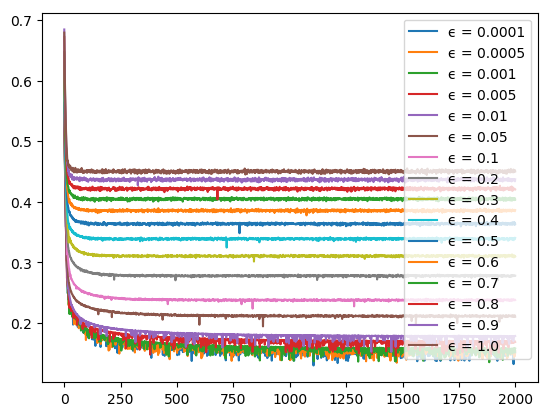

PyObject <matplotlib.legend.Legend object at 0x7f6addf190f0>

In [401]:
for i in 1:size(e_tab_was)[1]
     plot(dm_was[i], label="ϵ = $(e_tab[i])")
end
legend()

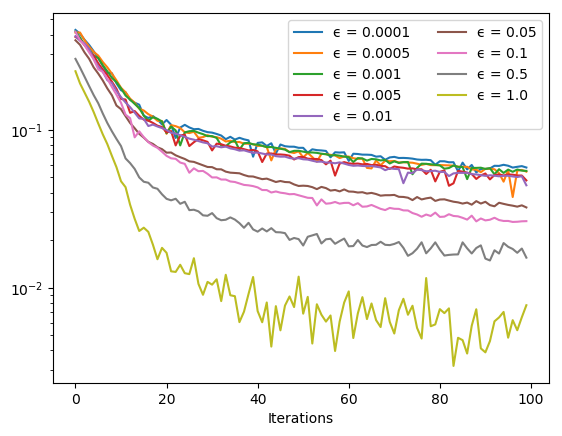

PyObject <matplotlib.legend.Legend object at 0x7f13a4f70668>

In [27]:
for i in 1:(size(e_tab_was)[1]-2)
    plot(dm_was[i][1:100]-minimum(dm_was[i]), label="ϵ = $(e_tab_was[i])")
    yscale("log")
end
plot(dm_was[11][1:100]-minimum(dm_was[11]), label="ϵ = $(e_tab_was[end-1])")
plot(dm_was[end][1:100]-minimum(dm_was[end]), label="ϵ = $(e_tab_was[end])")
yscale("log")
xlabel("Iterations")
legend(loc = 1, ncol=2)

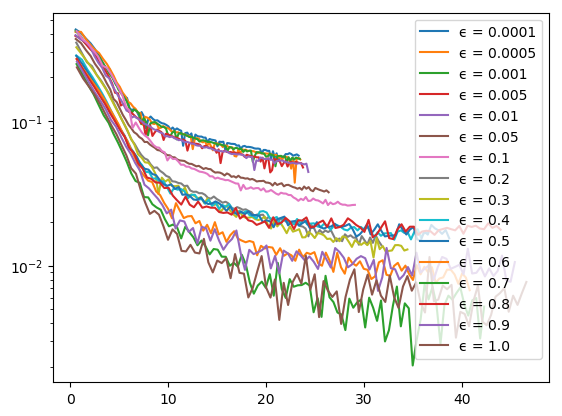

PyObject <matplotlib.legend.Legend object at 0x7f6adb653b00>

In [440]:
for i in 1:size(e_tab_was)[1]
    plot(cumsum(time_was[i][1:100]), dm_was[i][1:100]-mini_was[i], label="ϵ = $(e_tab[i])")
    yscale("log")
end
legend()

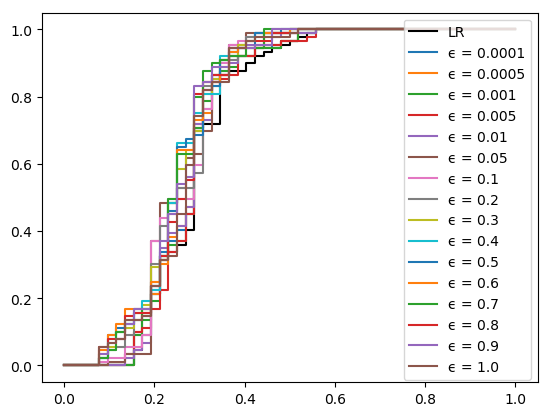

PyObject <matplotlib.legend.Legend object at 0x7f6addc1a7b8>

In [404]:
plot(fpr,tpr, color="black", label="LR")
for i in 1:size(e_tab_was)[1]
     plot(fpr1_was[i], tpr1_was[i], label="ϵ = $(e_tab[i])")
end
legend()

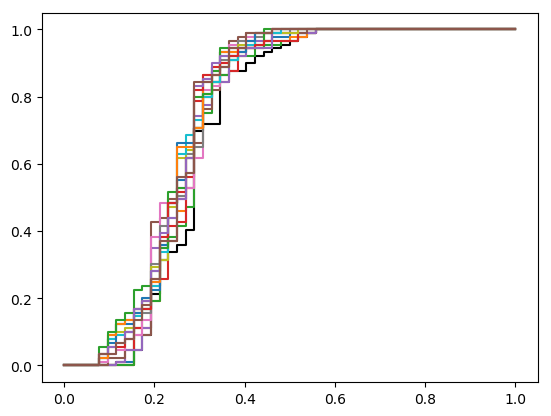

In [405]:
plot(fpr,tpr, color="black")
for i in 1:size(e_tab_was)[1]
     plot(fpr2_was[i], tpr2_was[i])
end

In [324]:
# Montrer pour différente de taille de dataset et regarder à partir de quel moment la méthode de base décroche

0.7134831460674158  0.7943262411347518
0.7255834053586863  0.7943262411347518
0.7270959377700951  0.7943262411347518
0.7234226447709594  0.7943262411347518
0.7210458081244597  0.8085106382978723
0.7268798617113224  0.8226950354609929
0.7400605012964563  0.8297872340425532
0.7402765773552291  0.8297872340425532
0.7441659464131374  0.8297872340425532
0.750648228176318  0.8368794326241135
0.7521607605877269  0.8368794326241135
0.7517286084701814  0.8297872340425532
0.7510803802938635  0.8297872340425532
0.7525929127052722  0.8297872340425532
0.746542783059637  0.8156028368794326
0.7497839239412273

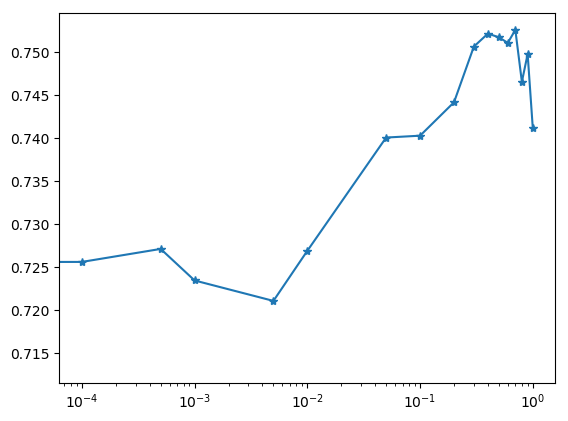

  0.8297872340425532
0.7411408815903198  0.8226950354609929


In [406]:
plt_was = []
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
push!(plt_was, roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:size(e_tab_was)[1]
    print(roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    push!(plt_was, roc_auc_score(df_aux[:,end], positive_rate(xr1_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr1_was[i], LogisticRegression())))
end
plot(vcat([0],e_tab_was),plt_was, marker="*")
xscale("log")

In [174]:
print(roc_auc_score(df_aux[:,end], positive_rate(xnormal,df_aux)))
print("  ")
println(accuracy_score(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
for i in 1:21
    print(roc_auc_score(df_aux[:,end], positive_rate(xr2_was[i],df_aux)))
    print("  ")
    println(accuracy_score(df_aux[:,end], pred(df_aux, xr2_was[i], LogisticRegression())))
end

0.7134831460674158  0.7943262411347518
0.7398444252376837  0.8014184397163121
0.7394122731201382  0.8014184397163121


LoadError: [91mBoundsError: attempt to access 2-element Array{Any,1} at index [3][39m

In [175]:
println(classification_report(df_aux[:,end], pred(df_aux, xnormal, LogisticRegression())))
println(classification_report(df_aux[:,end], pred(df_aux, xr1_was[3], LogisticRegression())))

             precision    recall  f1-score   support

       -1.0       0.87      0.52      0.65        52
        1.0       0.77      0.96      0.85        89

avg / total       0.81      0.79      0.78       141



LoadError: [91mBoundsError: attempt to access 2-element Array{Any,1} at index [3][39m

In [414]:
open("io-log-was-good.txt", "w") do f
    write(f, "xnormal = ")
    write(f, "$xnormal \n")
#     write(f, "fpr = ")
#     write(f, "$fpr \n")
#     write(f, "tpr = ")
#     write(f, "$tpr \n")
#     write(f, "dm_tab = ")
#     write(f, "$dm_tab \n")
#     write(f, "time_tab = ")
#     write(f, "$time_tab \n")
#     write(f, "xr1_tab = ")
#     write(f, "$xr1_tab \n")
#     write(f, "fpr1_tab = ")
#     write(f, "$fpr1_tab \n")
#     write(f, "tpr1_tab = ")
#     write(f, "$tpr1_tab \n")
    write(f, "dm_was = ")
    write(f, "$dm_was \n")
    write(f, "time_was = ")
    write(f, "$time_was \n")
    write(f, "xr1_was = ")
    write(f, "$xr1_was \n")
    write(f, "fpr1_was = ")
    write(f, "$fpr1_was \n")
    write(f, "tpr1_was = ")
    write(f, "$tpr1_was \n")
end

5513